### Import packages

In [ ]:
!pip install pathfinding

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import requests
import zipfile
import io
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
from typing import List
import pickle
import time
import itertools
import heapq
from IPython.display import display
from pathfinding.core.diagonal_movement import DiagonalMovement
from pathfinding.core.grid import Grid
from pathfinding.finder.a_star import AStarFinder

### Data mining

In [ ]:
url_string = 'https://www.movingai.com/benchmarks/street/street-map.zip'
r = requests.get(url_string, stream=True)
z = zipfile.ZipFile(io.BytesIO(r.content))
z.extractall('maps')

In [ ]:
url_string = 'https://www.movingai.com/benchmarks/street/street-scen.zip'
r = requests.get(url_string, stream=True)
z = zipfile.ZipFile(io.BytesIO(r.content))
z.extractall('scenarios')

In [ ]:
url_string = 'https://www.movingai.com/benchmarks/street/street-png.zip'
r = requests.get(url_string, stream=True)
z = zipfile.ZipFile(io.BytesIO(r.content))
z.extractall('images')

### Routines

#### Work with files

In [ ]:
!mkdir results

In [ ]:
def readMap(fileName: str) -> np.array:
    """
    Read map file, process it and return map object.
    While preprocessing maps passable terrain to 
    True and other to False.
    :param fileName: name of file .map
    :type fileName: str
    :return: shaped preprocessed array with map
    :rtype: np.array
    """
    map_path = os.path.join('maps/', fileName)
    with open(map_path, 'r') as map_file:
        data = map_file.read().split('\n')
        map_height = int(data[1].split()[1])
        map_width = int(data[2].split()[1]) 
        data = "".join(data[4:])
        #map = [True if x == '.' else False for x in data]
        map = [1 if x == '.' else 0 for x in data]
        map = np.array(map).reshape(map_width, map_height)
    return map

In [ ]:
def readScenario(fileName: str) -> pd.DataFrame:
    """
    Read scenario file, and return scenario object.
    :param fileName: name of file .scen
    :type fileName: str
    :return: data frame with scenario
    :rtype: pd.DataFrame
    """
    col_names = ['i', 'Map name', 'Width', 'Height', 'start_x', 'start_y', 'goal_x', 'goal_y', 'Path length']
    scenario_path = os.path.join('scenarios/', fileName)
    df = pd.read_csv(scenario_path, delim_whitespace=True, header=None, names=col_names, skiprows=1)  
    return df

#### A* algorithm

In [ ]:
def plot_astar(map: str, map_size: int, fileName: str, show: bool = False):
    """
    Visualize results of A* algorithm.
    :param map: outputted map with path
    :type map: str
    :param map_size: size of the output map
    :type map_size: int
    :param fileName: desired name of saved image
    :type filename: str
    :param show: whether to show the plot
    :type show: bool
    """
    map = map.split('\n')
    matrix = []
    mapper = {'|': 0, '+': 0, '-': 0, '#': 0, ' ': 1, 's': 2, 'x': 3, 'e': 4}
    for row in map:
        matrix.append([mapper[x] for x in list(row)])
    matrix = np.array(matrix).reshape(map_size, map_size)
    plt.ioff()
    fig, axs = plt.subplots(figsize=(25, 25))
    axs.matshow(matrix, cmap='gist_earth')
    plt.savefig('results/' + fileName + '.png')
    if show:
        plt.show()
    else:
        plt.close(fig)

In [ ]:
def run_astar(map: np.array, start_x: int, start_y: int, goal_x: int, goal_y: int, fileName: str, show: bool = False):
    """
    Run A* algorithm on setted environment.
    :param map: map for searching path
    :type map: np.array
    :param start_x: x coordinape of starting point
    :type start_x: int
    :param start_y: y coordinape of starting point
    :type start_y: int
    :param goal_x: x coordinape of ending point
    :type goal_x: int
    :param goal_y: y coordinape of ending point
    :type goal_y: int
    :param fileName: name of the map & scen used for output
    :type fileName: str
    :param show: whether to show the plot
    :type show: bool
    :return: path length, operations count, time count
    :rtype: int, int, int
    """
    grid = Grid(matrix=map)
    start = grid.node(start_x, start_y)
    end = grid.node(goal_x, goal_y)
    finder = AStarFinder(diagonal_movement=DiagonalMovement.always)
    t1 = time.perf_counter()
    path, runs = finder.find_path(start, end, grid)
    t2 = time.perf_counter()
    map_with_path = grid.grid_str(path=path, start=start, end=end)

    runName = '_' + str(start_x) + '_' + str(start_y) + '_' + str(goal_x) + '_' + str(goal_y) + '_' + 'Astar'
    text_file = open('results/' + fileName + runName + '.txt', 'w')
    text_file.write(map_with_path)
    text_file.close()

    plot_astar(map_with_path, map.shape[0] + 2, fileName + runName)

    return len(path), runs, t2 - t1

#### JPS algorithm

In ps1 realization of A* algorithm we used ordinary `List` as priority queue $Q$, which was sorted in the end of every iteration in order to get the node with minimal value of heuristic function afterwards. Of course, such implementation is not really efficient, although it was adequate to the scale of previous task. In this task we play with much bigger environments, thus we considered to organise priority queue through the [heap queue](https://docs.python.org/3/library/heapq.html) to be reasonable enhancement.

In [ ]:
class PriorityQueue():
    """
    Priority Queue implementation through the `heapq`.
    """
    def __init__(self):
        self.pq = []
        self.counter = itertools.count()
    
    def add_task(self, task, priority=0):
        """
        Add a new task.
        """
        count = next(self.counter)
        entry = [priority, count, task]
        heapq.heappush(self.pq, entry)
    
    def pop_task(self):
        """
        Remove and return the lowest priority task. 
        Raise KeyError if empty.
        """
        while self.pq:
            priority, count, task = heapq.heappop(self.pq)
            return task
        raise KeyError('Try to pop from an empty priority queue.')
    
    def is_empty(self):
        return len(self.pq) == 0

Below is implementation of adding new node to Priority Queue $Q$ and used heurisic function.

In [ ]:
# constants
UNEXPLORED = -1
OBSTACLE = -2
GOAL = -3
START = 0
SQRT2 = 2**0.5

In [ ]:
def octile(dx, dy):
    """
    Octile distance.
    Used for square grid with diagonal movement. Moving along X or Y costs 1
    while moving along diagonal requires sqrt(2).
    """
    f = SQRT2 - 1
    if dx < dy:
        return f * dx + dy
    else:
        return f * dy + dx

In [ ]:
def add_jump_point(point):
    """
    Add jump point to Priority Queue.
    Octile distance is used in heuristic.
    """
    global field, Q, goal_x, goal_y
    if point is not None:
        dx = goal_x - point[0]
        dy = goal_y - point[1]
        Q.add_task(point, field[point[0]][point[1]] + octile(dx, dy))

We should preprocess the map provided in `.map` files before applying the JPS to it. As well as both starting and goal points.

In [ ]:
def preprocess_input(map, start_x: int, start_y: int, end_x: int, end_y: int):
    new_map = []
    new_map.append([OBSTACLE for _ in range(np.shape(map)[0] + 2)])
    for line in map:
        new_map.append(np.concatenate(([OBSTACLE], line, [OBSTACLE])).tolist())
    new_map.append([OBSTACLE for _ in range(np.shape(map)[0] + 2)])
    new_map = np.array(new_map)
    new_map[new_map == 0] = OBSTACLE
    new_map[new_map == 1] = UNEXPLORED
    new_map[start_x][start_y] = START
    new_map[end_x][end_y] = GOAL
    start_x += 1
    start_y += 1
    end_x += 1
    end_y += 1
    return new_map, start_x, start_y, end_x, end_y

Reconstruction of the entire path from starting point to the goal is shown as follows.

In [ ]:
def get_jump_points(start_x, start_y):
    """
    Generate the list of jump points from start point to goal point.
    :param start_x: the x coordinate of the start point
    :type start_x: int
    :param start_y: the y coordinate of the start point
    :type start_y: int
    :return: list of jump points from start point to goal point
    :rtype: List((int, int))
    """
    global sources, goal_x, goal_y
    result = []
    curr_x, curr_y = goal_x, goal_y
    while curr_x != start_x or curr_y != start_y:
        result.append((curr_x, curr_y))
        curr_x, curr_y = sources[curr_x][curr_y]
    return [(start_x, start_y)] + result[::-1]

In [ ]:
def get_path(start_x, start_y):
    """
    Reconstruct the path provided with the list of jump points.
    :param start_x: the x coordinate of the start point
    :type start_x: int
    :param start_y: the y coordinate of the start point
    :type start_y: int
    :return: path from starting point to goal point
    :rtype: List((int, int))
    """
    jump_points = get_jump_points(start_x, start_y)
    if not jump_points:
        return jump_points
    curr_x, curr_y = jump_points[0]
    path = [(curr_x, curr_y)]
    for i in range(len(jump_points) - 1):
        while curr_x != jump_points[i + 1][0] or curr_y != jump_points[i + 1][1]:
            curr_x += np.sign(jump_points[i + 1][0] - jump_points[i][0])
            curr_y += np.sign(jump_points[i + 1][1] - jump_points[i][1])
            path.append((curr_x, curr_y))
    return path

Here is main routines for diagonal search and non-diagonal one.

In [ ]:
class FoundPath(Exception):
    pass

In [ ]:
def search_non_diagonal(start_x, start_y, dir_x, dir_y):
    global field, sources
    curr_x, curr_y = start_x, start_y
    curr_cost = field[start_x][start_y]
    while True:
        curr_x += dir_x
        curr_y += dir_y
        curr_cost += 1
        if field[curr_x][curr_y] == UNEXPLORED:
            field[curr_x][curr_y] = curr_cost
            sources[curr_x][curr_y] = start_x, start_y
        elif field[curr_x][curr_y] == GOAL:
            field[curr_x][curr_y] = curr_cost
            sources[curr_x][curr_y] = start_x, start_y
            raise FoundPath()
        # elif field[curr_x][curr_y] == OBSTACLE:
        #     return None
        # else:
        #     print(f'{field[curr_x][curr_y] = }')
        #     raise ValueError()
        else:
            return None

        if dir_x == 0:
            if field[curr_x + 1][curr_y] == OBSTACLE and field[curr_x + 1][curr_y + dir_y] != OBSTACLE:
                return (curr_x, curr_y)
            if field[curr_x - 1][curr_y] == OBSTACLE and field[curr_x - 1][curr_y + dir_y] != OBSTACLE:
                return (curr_x, curr_y)
        elif dir_y == 0:
            if field[curr_x][curr_y + 1] == OBSTACLE and field[curr_x + dir_x][curr_y + 1] != OBSTACLE:
                return (curr_x, curr_y)
            if field[curr_x][curr_y - 1] == OBSTACLE and field[curr_x + dir_x][curr_y - 1] != OBSTACLE:
                return (curr_x, curr_y)

In [ ]:
def search_diagonal(start_x, start_y, dir_x, dir_y):
    global field, sources
    curr_x, curr_y = start_x, start_y
    curr_cost = field[start_x][start_y]
    while True:
        curr_x += dir_x
        curr_y += dir_y
        curr_cost += SQRT2
        if field[curr_x][curr_y] == UNEXPLORED:
            field[curr_x][curr_y] = curr_cost
            sources[curr_x][curr_y] = start_x, start_y
        elif field[curr_x][curr_y] == GOAL:
            field[curr_x][curr_y] = curr_cost
            sources[curr_x][curr_y] = start_x, start_y
            raise FoundPath()
        else:
            return None
        if field[curr_x + dir_x][curr_y] == OBSTACLE and field[curr_x + dir_x][curr_y + dir_y] != OBSTACLE:
            return (curr_x, curr_y)
        else: 
            #jump_point = search_non_diagonal(curr_x, curr_y, dir_x, 0)
            #if jump_point is not None:
            #    return (curr_x, curr_y)
            add_jump_point(search_non_diagonal(curr_x, curr_y, dir_x, 0))
        if field[curr_x][curr_y + dir_y] == OBSTACLE and field[curr_x + dir_x][curr_y + dir_y] != OBSTACLE:
            return (curr_x, curr_y)
        else:
            #jump_point = search_non_diagonal(curr_x, curr_y, 0, dir_y)
            #if jump_point is not None:
            #    return (curr_x, curr_y)
            add_jump_point(search_non_diagonal(curr_x, curr_y, 0, dir_y))

In [ ]:
def run_jps(map: np.array, start_x: int, start_y: int, end_x: int, end_y: int, fileName: str, show: bool = False):
    """
    Run JPS algorithm on setted environment.
    :param map: map for searching path
    :type map: np.array
    :param start_x: x coordinape of starting point
    :type start_x: int
    :param start_y: y coordinape of starting point
    :type start_y: int
    :param end_x: x coordinape of ending point
    :type end_x: int
    :param end_y: y coordinape of ending point
    :type end_y: int
    :param fileName: name of the map & scen used for output
    :type fileName: str
    :param show: whether to show the plot
    :type show: bool
    :return: path length, operations count, time count
    :rtype: int, int, int
    """
    global field, sources, Q, goal_x, goal_y
    goal_x, goal_y = end_x, end_y 
    field = np.array([[i for i in j] for j in map])
    #field = map.copy()
    sources = [[(None, None) for i in field[0]] for j in field]
    Q = PriorityQueue()
    add_jump_point((start_x, start_y))

    while not Q.is_empty():
        point_x, point_y = Q.pop_task()
        try:
            add_jump_point(search_non_diagonal(point_x, point_y, 1, 0))
            add_jump_point(search_non_diagonal(point_x, point_y, -1, 0))
            add_jump_point(search_non_diagonal(point_x, point_y, 0, 1))
            add_jump_point(search_non_diagonal(point_x, point_y, 0, -1))
            add_jump_point(search_diagonal(point_x, point_y, 1, 1))
            add_jump_point(search_diagonal(point_x, point_y, 1, -1))
            add_jump_point(search_diagonal(point_x, point_y, -1, 1))
            add_jump_point(search_diagonal(point_x, point_y, -1, -1))
        except FoundPath:
            return get_path(start_x, start_y)
    raise ValueError("No path is found")


In [ ]:
map = [                       
[-2, -2, -2, -2, -2, -2, -2, -2, -2, -2], 
[-2,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1, -2], 
[-2,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1, -2], 
[-2,  -1,  -1,  -1,  -1, -2,  -1,  -1,  -1, -2], 
[-2,  -1,  -1,  -1,  -1, -2, -2,  -1,  -1, -2], 
[-2,  -1,  -1, -2, -2, -2,  -1,  -1,  -1, -2], 
[-2,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1, -2], 
[-2,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1, -2], 
[-2,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1, -2], 
[-2, -2, -2, -2, -2, -2, -2, -2, -2, -2] ]
#print(field[0][0])
path = run_jps(map, 3, 2, 8, 8, '')
print(len(path))

field[curr_x][curr_y] = 2


ValueError: ignored

In [ ]:
map = readMap('Berlin_0_512.map')
df = readScenario('Berlin_0_512.map.scen').iloc[-1:]
start_y = int(df['start_x'])
start_x = int(df['start_y'])
end_y = int(df['goal_x'])
end_x = int(df['goal_y'])
mapp, start_xp, start_yp, end_xp, end_yp = preprocess_input(map, start_x, start_y, end_x, end_y)
#print(map[0])
path = run_jps(mapp, start_xp, start_yp, end_xp, end_yp, '')
print(len(path))

ValueError: ignored

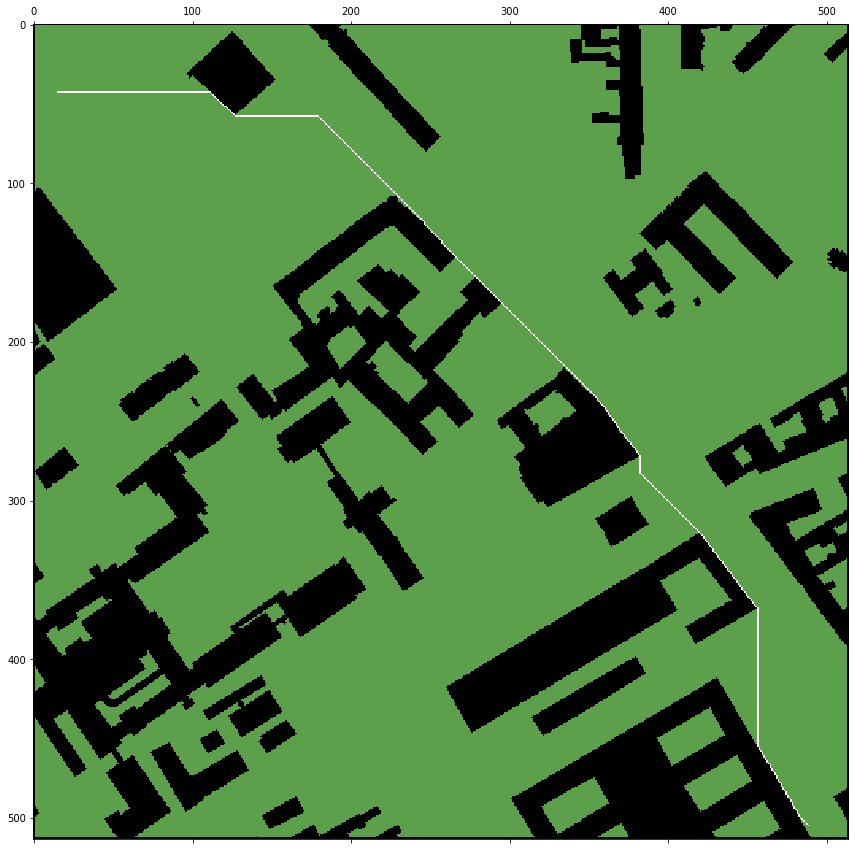

In [ ]:
field = []
field.append([-2 for _ in range(np.shape(map)[0] + 2)])
for line in map:
    field.append(np.concatenate(([-2], line, [-2])).tolist())
field.append([-2 for _ in range(np.shape(map)[0] + 2)])
field = np.array(field)
field[field == 0] = -2
field[field == 1] = -1
for point in full_path:
    field[point[0]][point[1]] = 0
fig, axs = plt.subplots(figsize=(15, 15))
axs.matshow(field, cmap='gist_earth')
plt.show()

In [ ]:
def plot_jps(map: str, map_size: int, fileName: str, show: bool = False):
    """
    Visualize results of A* algorithm.
    :param map: outputted map with path
    :type map: str
    :param map_size: size of the output map
    :type map_size: int
    :param fileName: desired name of saved image
    :type filename: str
    :param show: whether to show the plot
    :type show: bool
    """
    map = map.split('\n')
    matrix = []
    mapper = {'|': 0, '+': 0, '-': 0, '#': 0, ' ': 1, 's': 2, 'x': 3, 'e': 4}
    for row in map:
        matrix.append([mapper[x] for x in list(row)])
    matrix = np.array(matrix).reshape(map_size, map_size)
    plt.ioff()
    fig, axs = plt.subplots(figsize=(25, 25))
    axs.matshow(matrix, cmap='gist_earth')
    plt.savefig('results/' + fileName + '.png')
    if show:
        plt.show()
    else:
        plt.close(fig)

#### Running all

In [ ]:
def run(map_size: List = [512], scen_num: int = 1, algoritms: List = ['A*', 'JPS']):
    """
    Run all algorithms on selected maps and scenarios.
    While selecting scenario check desired `map_size`
    and choose top `scen_num` from descending path
    length list.
    :param map_size: desired sizes of map
    :type map_size: List[int]
    :param scen_num: desired amount of scenarios per map
    :type scen_num: int
    :param algoritms: desired algorithms to run
    :type algoritms: List[str]
    """
    col_names = ['Map name', 'Width', 'Height', 'start_x', 'start_y', 'goal_x', 'goal_y', 'Path length', 'Operations', 'Time', 'Algorithm']
    res_df = pd.DataFrame(columns=col_names)
    
    for path in os.listdir('scenarios/'):
        name = re.split('_|\.', path)
        if name[1] == '0' and int(name[2]) in map_size:
            fileName = name[0] + '_' + name[1] + '_' + name[2]
            map = readMap(fileName + '.' + name[3])
            scen_df = readScenario(path).iloc[-scen_num:]
            for i in range(scen_num):
                row = scen_df.iloc[i]
                start_x = int(row['start_x'])
                start_y = int(row['start_y'])
                goal_x = int(row['goal_x'])
                goal_y = int(row['goal_y'])
                for algorithm in algoritms:
                    if algorithm == 'A*':
                        path_len, runs, time = run_astar(map, start_x, start_y, goal_x, goal_y, fileName)
                        result = [fileName, map.shape[0], map.shape[1], start_x, start_y, goal_x, goal_y, path_len, runs, time, 'A*']
                        row = pd.DataFrame([result], columns=col_names)
                        res_df = res_df.append(row, ignore_index=True)
                    elif algorithm == 'JPS':
                        pass
                    else:
                        pass
    res_df.to_pickle('results/results.pkl')

### Results

In [ ]:
run()

In [ ]:
unpickled_df = pd.read_pickle("results/results.pkl")  
unpickled_df.head(100)

,Map name,Width,Height,start_x,start_y,goal_x,goal_y,Path length,Operations,Time,Algorithm
0,Paris_0_512,512,512,509,48,12,495,551,39925,11.650400,A*
1,Berlin_0_512,512,512,487,504,14,42,612,35844,10.791809,A*
2,Shanghai_0_512,512,512,466,491,33,1,526,28465,8.527070,A*
3,Boston_0_512,512,512,24,458,263,9,571,127135,32.127829,A*
4,Denver_0_512,512,512,445,1,8,511,571,41641,10.578429,A*
5,Milan_0_512,512,512,506,341,110,3,571,134604,37.937904,A*
6,London_0_512,512,512,214,26,51,199,675,68016,10.317416,A*
7,NewYork_0_512,512,512,452,486,14,7,545,41103,14.148155,A*
8,Moscow_0_512,512,512,67,499,502,6,552,16188,3.537226,A*
9,Sydney_0_512,512,512,63,510,509,10,545,31189,8.190929,A*
